In [1]:
# Import necessary library needed for the model training
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split 
from sklearn import utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
import tensorflow as tf
py.init_notebook_mode(connected=True)
%matplotlib inline
# Read the data set
data = pd.read_csv("C:/Users/waghm/Desktop/D1.csv", index_col="Timestamp")
# View data info
data.info()

# View data rows
data.head()

# Check latest date of data
data.tail()


Using TensorFlow backend.


<class 'pandas.core.frame.DataFrame'>
Index: 10766 entries, 1/01/2017 10:00 to 25/03/2018 23:00
Data columns (total 7 columns):
Open                 10766 non-null float64
High                 10766 non-null float64
Low                  10766 non-null float64
Close                10766 non-null float64
Volume_(BTC)         10766 non-null float64
Volume_(Currency)    10766 non-null float64
Weighted_Price       10766 non-null float64
dtypes: float64(7)
memory usage: 672.9+ KB


Open     High      Low    Close  Volume_(BTC)  \
Timestamp                                                            
25/03/2018 19:00  8519.44  8579.52  8482.53  8523.93    479.890020   
25/03/2018 20:00  8506.84  8530.89  8398.24  8491.48    405.761062   
25/03/2018 21:00  8481.56  8582.04  8455.01  8538.60    279.999621   
25/03/2018 22:00  8535.68  8551.48  8501.08  8512.33    132.382145   
25/03/2018 23:00  8520.86  8540.48  8443.00  8491.98    194.822575   

                  Volume_(Currency)  Weighted_Price  
Timestamp                                            
25/03/2018 19:00        4086971.278     8540.651165  
25/03/2018 20:00        3427845.018     8471.552153  
25/03/2018 21:00        2389833.890     8545.464867  
25/03/2018 22:00        1128237.584     8528.889670  
25/03/2018 23:00        1651794.040     8489.190251

In [2]:
# Plot line graph base on Weighted Price
btc_trace=go.Scatter(x=data.index, y=data['Weighted_Price'], name='Price')
py.iplot([btc_trace])

# Fill value 0 data points on Weighted Price with NaN and then use ffill method to fill values
data['Weighted_Price'].replace(0, np.nan, inplace=True)
data['Weighted_Price'].fillna(method='ffill', inplace=True)


# Plot new line graph again on Weighted Price with newly filled values
btc_trace = go.Scatter(x=data.index, y=data['Weighted_Price'], name='Price')
py.iplot([btc_trace])

# Fill value 0 data points on Volume_(BTC) with NaN and then use ffill method to fill values
data['Volume_(BTC)'].replace(0, np.nan, inplace=True)
data['Volume_(BTC)'].fillna(method='ffill', inplace=True)


# Plot new line graph again on Weighted Price with newly filled values
btc_trace = go.Scatter(x=data.index, y=data['Weighted_Price'], name='Price')
py.iplot([btc_trace])

# Fill value 0 data points on Volume_(Currency) with NaN and then use ffill method to fill values
data['Volume_(Currency)'].replace(0, np.nan, inplace=True)
data['Volume_(Currency)'].fillna(method='ffill', inplace=True)


# Plot new line graph again on Weighted Price with newly filled values
btc_trace = go.Scatter(x=data.index, y=data['Volume_(Currency)'], name='Price')
py.iplot([btc_trace])

# Fill value 0 data points on Open with NaN and then use ffill method to fill values
data['Open'].replace(0, np.nan, inplace=True)
data['Open'].fillna(method='ffill', inplace=True)


# Plot new line graph again on Weighted Price with newly filled values
btc_trace = go.Scatter(x=data.index, y=data['Open'], name='Price')
py.iplot([btc_trace])

# Fill value 0 data points on High with NaN and then use ffill method to fill values
data['High'].replace(0, np.nan, inplace=True)
data['High'].fillna(method='ffill', inplace=True)


# Plot new line graph again on Weighted Price with newly filled values
btc_trace = go.Scatter(x=data.index, y=data['High'], name='Price')
py.iplot([btc_trace])

# Fill value 0 data points on Low with NaN and then use ffill method to fill values
data['Low'].replace(0, np.nan, inplace=True)
data['Low'].fillna(method='ffill', inplace=True)


# Plot new line graph again on Weighted Price with newly filled values
btc_trace = go.Scatter(x=data.index, y=data['Low'], name='Price')
py.iplot([btc_trace])

# Fill value 0 data points on Close with NaN and then use ffill method to fill values
data['Close'].replace(0, np.nan, inplace=True)
data['Close'].fillna(method='ffill', inplace=True)


# Plot new line graph again on Weighted Price with newly filled values
btc_trace = go.Scatter(x=data.index, y=data['Close'], name='Price')
py.iplot([btc_trace])

# Function to convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0 , -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Get all data values
values = data[['Weighted_Price'] + ['Volume_(BTC)'] + ['Volume_(Currency)'] + ['Open'] +['High'] + ['Low'] + ['Close']].values
values = values.astype('float32')
# Normalise features to range from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [3]:
# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

# Drop unnecessary columns
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.010739   0.005478   0.000929   0.010837   0.010584   0.011228   
2   0.010763   0.012607   0.002148   0.010903   0.010618   0.011296   
3   0.010830   0.012337   0.002106   0.010938   0.010730   0.011381   
4   0.010917   0.007471   0.001274   0.011077   0.010766   0.011435   
5   0.010811   0.005605   0.001826   0.011099   0.010746   0.011325   

   var7(t-1)   var1(t)  
1   0.010903  0.010763  
2   0.010938  0.010830  
3   0.011083  0.010917  
4   0.011099  0.010811  
5   0.010953  0.010807  


In [4]:
# Split data to 70% training, 30% testing
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [5]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7535, 7) (7535,) (3230, 7) (3230,)


In [15]:
regressor=SVR(kernel='linear',degree=1)
regressor.fit(train_X,train_y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=1, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [16]:

yhat = regressor.predict(test_X)

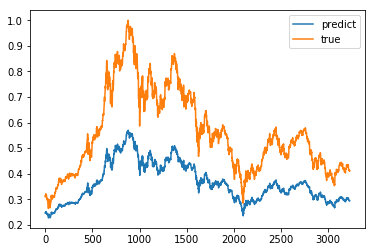

In [17]:
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

C:\Users\waghm\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



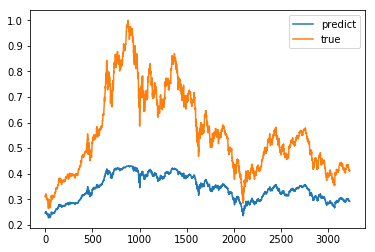

In [18]:
regressor=SVR(kernel='rbf')
regressor.fit(train_X,train_y)
yhat = regressor.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

C:\Users\waghm\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



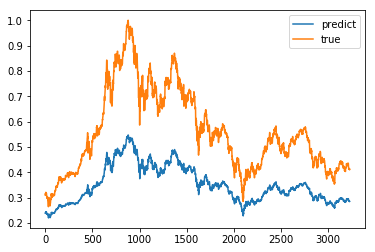

In [27]:
regressor=SVR(kernel='poly', degree=20, epsilon=.1, coef0=1)
regressor.fit(train_X,train_y)
yhat = regressor.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

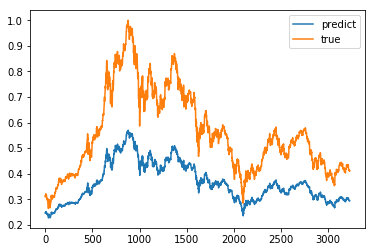

In [33]:
regressor=SVR(kernel='linear', degree=1)
regressor.fit(train_X,train_y)
yhat = regressor.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [43]:
SVR(kernel='rbf',epsilon=1.0,degree=3)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=1.0,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [44]:
regressor.fit(train_X,train_y)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=1, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [45]:
yhat = regressor.predict(test_X)


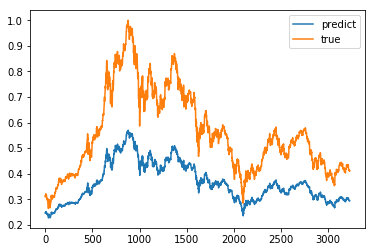

In [46]:
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [64]:
regressor=SVR(kernel='rbf', max_iter=300, gamma='auto', degree=100)

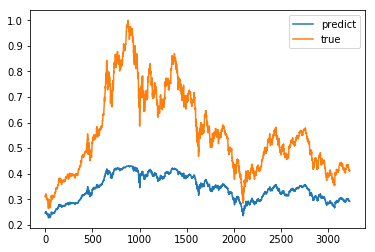

In [65]:
regressor.fit(train_X,train_y)
yhat = regressor.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [70]:
rmse = sqrt(mean_squared_error(test_y, yhat))

In [71]:
print(rmse)

0.24518580619000493


In [72]:
from sklearn.metrics import r2_score
print(r2_score(test_y,yhat))

-1.276100658000788


In [74]:
from sklearn.metrics import explained_variance_score
explained_variance_score(test_y, yhat)

0.5116849494928464